## Week 3: Gradients and Optimization

### Outline
- Gradient descent
- Stochasticity, the explore-exploit tradeoff, global vs. local
- Numerical vs. analytic vs. automatic differentiation
- Automatic differentiation and machine learning

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

%matplotlib notebook
%matplotlib notebook
#matplotlib.use('nbAgg', warn=False, force=True)
sns.set(font_scale=1.)
sns.set_style('white')

Recap:
    - Models
    - Cost functions
    - Maximum likelihood estimation

- What do we already know? What are we assuming?
- What are we trying to (teach machines to) learn?

### Gradient Descent


- Falling down a parabola deterministically
- Local minima: falling down the wrong side of a quartic
- Stochasticity and "tunneling"
- Multiple dimensions: fastest descent = gradient; Wiki image
- Real situations (can't analytically solve for minima)
- The parabola is the cost function, not the generating function! The generating function can have arbitrarily complex inputs and outputs. Cost functions map arbitrarily complex inputs to scalars.

$$L(\theta) = \theta^2$$

In [8]:
def cost(theta):
    cost = theta ** 2
    return cost

<IPython.core.display.Javascript object>


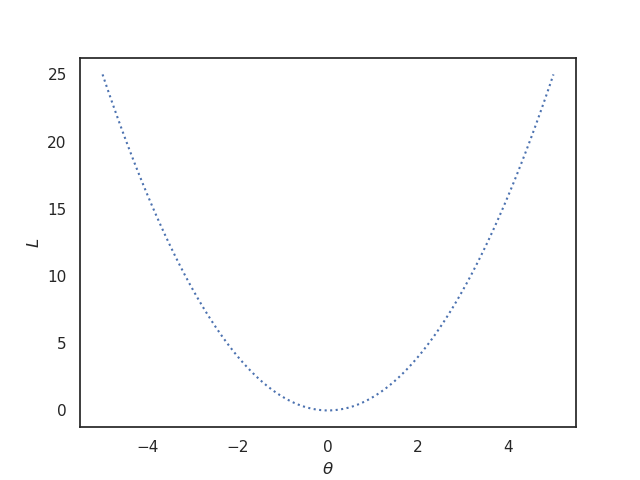

In [9]:
bounds = (-5, 5)
N_plot = 100

def get_cost_curve(cost, bounds, n):  
    """"""
    thetas = np.linspace(*bounds, n)
    costs = cost(thetas)
    return np.array((thetas, costs))

cost_curve = get_cost_curve(cost, bounds, N_plot)

fig, ax = plt.subplots()
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('$L$')
ax.plot(*cost_curve, ':')
plt.show()

It's pretty obvious what the minimum is, and we can solve it analytically with almost no effort.

\begin{align}
\frac{dL}{d\theta} &= 2\theta \\
0 &= 2\theta \\
0 &= \theta
\end{align}

In [10]:
def cost_d(theta):
    cost_d = 2 * theta
    return cost_d

Let's say we can't solve it by setting to 0 (usually true), and assume it's too costly to check every possible grid point (curse of dimensionality!), e.g. choose the minimum in `cost_plot` after evaluating at `N_plot` points.

Often we have an initial estimate for the value of the parameter, and can calculate the cost function and the derivative of the cost function at that point.

In [11]:
def tangent(theta, cost, cost_d=None, length=0.5, descent=False):
    """Return vectors of 2D coordinates for a tangent to the `cost`. 
    
    Args:
        theta (float): Value of interest of the parameter of the function `cost`.
        cost (function): Function of theta. Scalar.
        cost_d (function):  Function returning the derivative (by theta) of `cost`.
        length (float): Length of the tangent line.
        descent (bool): If `True`, line is asymmetric, pointing 'downhill'.
    """
    m = cost_d(theta)
    if descent:
        if m > 0:
            segment_bounds = (theta - length, theta)
        else:
            segment_bounds = (theta, theta + length)
    else:
        segment_bounds = (theta - 0.5 * length, 
                        theta + 0.5 * length)
    segment_bounds = np.array(segment_bounds)
    
    return segment_bounds, cost(segment_bounds)

Derivative of cost: 8


<IPython.core.display.Javascript object>


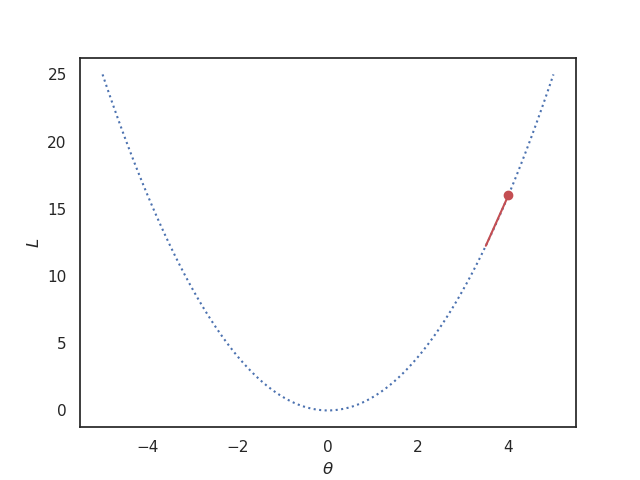

In [12]:
theta_0 = 4  # starting point
cost_0 = cost(theta_0)
print("Derivative of cost: {}".format(cost_d(theta_0)))

fig, ax = plt.subplots()
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('$L$')
ax.plot(*cost_curve, ':')
ax.plot(theta_0, cost_0, 'ro')  
ax.plot(*tangent(theta_0, cost, cost_d, descent=True), 'r')
plt.show()

The derivative at this point is 8. This is positive, so if we move in the direction of positive $\theta$, the cost will increase. This is the opposite of what we want. 

The sign (positive or negative) of the derivative is the opposite of the sign of the quantity we need to add to the parameter $\theta$ to minimize it. (Verify for yourself.) But by how much? Say we move by -8. 

<img src='./img/tangent-1.png'>

Our new position is $\theta=-4$, and the derivative is -8. Clearly if we move by $\Delta\theta=-(-8)=+8$, we'll be back where we started. Unless we take smaller steps, we'll never reach the minimum. 

There is no obvious connection between the magnitude of the derivative and the magnitude of the step we should take. Consider that if the cost has units $[L]$ and $\theta$ has units $[\theta]$, the derivative of the cost has units $[L]/[\theta]$, which are not additive with units of $[\theta]$. The sign tells us what direction to take to find the minimum, but not how far to go. That is usually unknown.

Therefore, to control how far to move, we take steps of $\eta\frac{dL}{d\theta}$, where $\eta$ is the factor (called the *learning rate*) by which we scale the derivative to calculate our step size. 

In this case, it seems reasonable to choose a value $0<\eta<1$. Let's say we start at our original point and choose $\eta=0.25$. (In this case $\eta=0.5$ is optimal since a step size of $0.5(8)=4$ will land us right on the minimum---but we don't normally have this information!)

In [13]:
learn_rate = 0.25

Our update rule is:
$$\theta_{i+1}=\theta_i - \eta\frac{dL}{d\theta}$$

In [14]:
def update_theta(theta, cost_d, learn_rate): 
    """Update the parameter `theta` by gradient descent."""
    theta = theta - learn_rate * cost_d(theta)  # participant
    return theta

In [15]:
# start the iterations (steps) at our original estimate
theta = theta_0
cost_ = cost_0

Derivative of cost: 2.0
Change in cost across step: -3.0


<IPython.core.display.Javascript object>


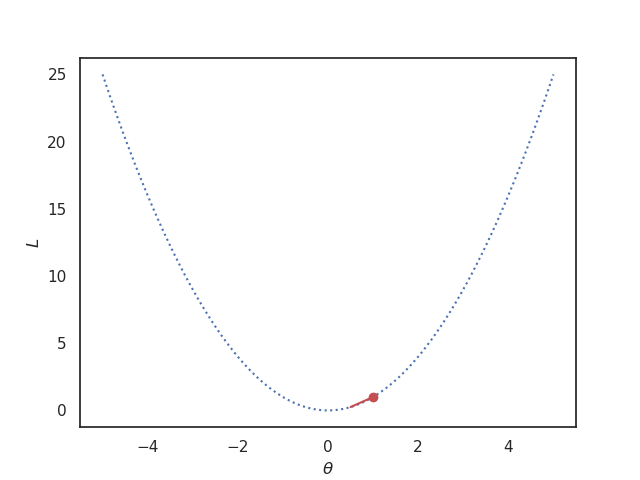

In [17]:
# single step per cell execution
cost_before = cost_  # participant?
theta = update_theta(theta, cost_d, learn_rate)  
cost_ = cost(theta)

cost_change = cost_ - cost_before

print("Derivative of cost: {}".format(cost_d(theta)))
print("Change in cost across step: {}".format(cost_change))

fig, ax = plt.subplots()
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('$L$')
ax.plot(*cost_curve, ':')
ax.plot(theta, cost_, 'ro')
ax.plot(*tangent(theta, cost, cost_d, descent=True), 'r')
plt.show()

This is Zeno's paradox. We'll never quite reach the minimum (at a constant learning rate), but we can get close enough for any practical purpose.

Now we'll write functions to automate these iterations and animate the plotting, so we can investigate arbitrary 1D descent problems:

In [18]:
def descent_points(theta_0, cost, cost_d, learn_rate, steps=None, tol=1e-6):
    """Calculate series of points in """
    thetas = [theta_0]
    costs = [cost(theta_0)]
    
    while True:
        thetas.append(update_theta(thetas[-1], cost_d, learn_rate))
        costs.append(cost(thetas[-1]))
        if len(thetas) == steps:
            break
        else:
            if np.abs(costs[-1] - costs[-2]) < tol:
                break
                
    return np.transpose((thetas, costs))

def descent_tangents(points, cost, cost_d):
    """"""
    steps = len(points)
    tangents = np.zeros((steps, 2, 2))
    for j in range(steps):
        tangents[j, :] = tangent(points[j, 0], cost, cost_d, descent=True)
    return tangents

In [19]:
def descent_plot_prep(theta_0, bounds, cost, cost_d, learn_rate, steps=None, tol=1e-6):
    """"""
    points = descent_points(theta_0, cost, cost_d, learn_rate, steps=steps, tol=tol)
    tangents = descent_tangents(points, cost, cost_d)
    curve = get_cost_curve(cost, bounds, 100)
    return points, tangents, curve

In [20]:
def animate_descent(points, tangents=None, curve=None, **kwargs):
    """"""
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel('$L$')
    
    if curve is not None:
        cost_curve = ax.plot(*curve, ':')
    estimate, = ax.plot(*points[0], 'ro')
    if tangents is not None:
        tangent, = ax.plot(*tangents[0], 'r')

    def animate(i): 
        estimate.set_data(*points[i])  # participant
        if tangents is not None:
            tangent.set_data(*tangents[i])
        return estimate, tangent
    
    anim = FuncAnimation(fig, animate, blit=True, **kwargs)
    return anim

Note that it's best practice to separate algorithms (in the form of functions or class methods) from data, including specific values for model inputs or parameters. This tends to make code more general/easy to read. Example: specific labels used in `animate_descent`: assumes a form to the problem.

Now we only have to specify the parameters followed by a couple lines of code.

<IPython.core.display.Javascript object>


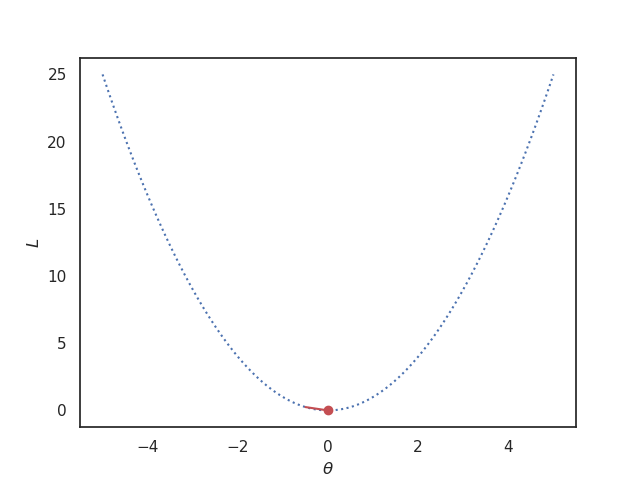

In [21]:
theta_0 = 4
bounds = (-5, 5)
learn_rate = 0.1
tol = 1e-6
interval = 500  # higher = longer delay between animation frames

points, tangents, curve = descent_plot_prep(theta_0, bounds, cost, cost_d, learn_rate, tol=tol)
anim = animate_descent(points, tangents, curve, interval=interval)
plt.draw()

What happens if you change the learning rate? The starting point? Tolerance?

### Local minima

Let's define a slightly more complex cost function

In [23]:
def cost(theta):
    cost = (0.9 * theta**4) + (4 * theta**3) + (5.7 * theta**2) + (3 * theta)
    return cost

def cost_d(theta):
    cost_d = (3.6 * theta**3) + (12 * theta**2) + (11.4 * theta) + 3  # participant
    return cost_d

This is a quartic function with two minima:
<img src='./img/quartic.png'>

Let's see what happens if we perform gradient descent to the same tolerance used in the quadratic example. For the first run, we'll use a smaller learning rate than before.

<IPython.core.display.Javascript object>


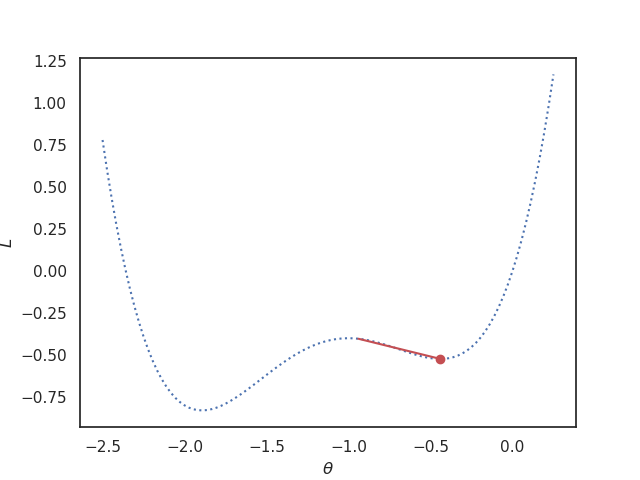

In [29]:
theta_0 = 0.25  
bounds = (-2.5, 0.25)
learn_rate = 0.1
tol = 1e-6

points, tangents, curve = descent_plot_prep(theta_0, bounds, cost, cost_d, learn_rate, tol=tol)
anim = animate_descent(points, tangents, curve, interval=interval)
plt.draw()

What happens when you increase or decrease the learning rate?

How to avoid traps?
- Increase learning rate. 
  - Too low: Inefficient (slow).
  - Too high: Unstable (variable).
  - Speed-accuracy tradeoff.
- More complex exploration strategies. Stochasticity.

### Cost functions
- May be hard to differentiate.
- Supervised learning: distance between model output and target
  - Usually not solvable due to non-linearities.

Remember from week 2: linear regression using MSE = quadratic cost function with analytic solution.
$$\nabla_w\textrm{MSE} = 0$$
$$\nabla_w\frac{1}{m}\sum_i(\hat{y}_i-y_i)^2 = 0$$
$$ ... $$
$$w = (X^TX)^{-1}X^Ty$$

<img src="./img/linreg_weight.png">

<img src="./img/linreg_mse.png">

### Multidimensional case
- Typical
    - Curse of dimensionality: Usually easy to check the entire range in the 1D case.
- Gradient instead of derivative: 
    - Extension of reasoning about signs (moving down a hyperplane rather than a tangent line)
    - *Relative* magnitudes of different parts of the gradient matter for direction of max descent. 

### Stochastic gradient descent
- Use subsets of dataset rather than full dataset---computational limitations
- Approximation of "true" gradient

### Types of differentiation
#### Symbolic
As above.
Limitations.
#### Numerical
Finite differences etc.
e.g. evaluate cost at small steps surrounding current point and take the difference
Limitation: inefficient.
#### Automatic
Chain rule. Connection to backprop?